#### Analysis of multiple stocks - for simulation over the course of 2 years (bi-weekly buy in)

Goal: This script simulates 2 years of bi-weekly prediction/closing_cost determinations and simulates for a series of chosen stocks if it is better to invest a consistent price or buy in higher/lower depending on the current performance of the stock.

Take any number of stocks and run a trendline through multiple 1 year cycles, creating a linear prediction to be applied bi-weekly. Assess the theoretical performance of adjusting bi-weekly contributions as compared to contributing a consistent amount every other week.


In [226]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
from sys import exit

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [227]:
### doing
# assn more descriptive variable, list names
    # invest every monday, invest every other monday, etc

### To do
# Clean up code
# I'm picking heavy hitter stocks and then pretending I've been investing for 2 years
    # I need to pick a series of random stocks and see if I still beat baseline
# fix the copy warnings
# be able to do any periods of time, not just days - make it 'units' of time
    # so I can check on hypothetical minute to minute trading
# Start testing buy/sell every period based on a set budget
    # will likely be a big job. maybe a lot of changes needed
    # will possibly need to make it it's own script

### Fixed
# are all ranges 1-260 or are some 0-259? - one of them was corrected, the one that sets the pred independent variable (aka index)
# test the dynamic roll_days - is it implemented everywhere it should be and everything works as expected? - seems good now
# Fix the graphs to be dynamic for dates - esp the 3 graphs stuck together - can I make the number of stuck visuals dynamic? - dropped for now
# Fix the final statement to say profit/loss or above/below dynamically
    # seems to have an issue with the reversal of percents when the total profits are negative
    # need to test with net loss stocks
# Test for different 3 year periods of time
# Fact check the dynamic dates - is everything really working?
# I really need to fix the invest days to be always on Monday or something instead of every 10 trading days
    # I can't actually trust this method until I do this
    # probably means actually using time series instead of the index replacement -- nope
# be able to run on SP500
    # SP500 core profit is unbeleiveable - any error in the code? -- a few 'weeks' variables were kept stagnant as 49
# error checking on too much history run
    # have a whole section dedicated to it and say which stock and by how much it misses
# Make a path to DL data and call to it again w/o issues
    # For flights w/o internet
# be able to do one stock at a time -- OR be able to bypass
# 3 options: every week, 2 weeks, 4 weeks, is ok if I can't do fully dynamic
# test nth week variable for odd n's that create non-integers, like investing on 3rd weeks
    # invest_weeks must be an integer
    # re-check all new facets of weeks and invest_weeks
# convert 'y' years of data to be 'w?' weeks.
    # calculate exactly how much data are needed based on weeks to look back + length of the regression. with a week or two buffer
# make the invest period dynamic
# make some logic to warn when I'm asking for too much data and one of the stocks hasn't been around long enough
# Fact check by trying different stocks entirely - do a series of poorly performing stocks, high performing stocks, and a mix




In [228]:
##### User choices go here #####

# choose stocks of interest
# stocks chosen must all have data for full range of dates
stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MDB', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'] # core list
# stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SQ', 'TSM']
# stock_list = ['AAPL', 'SQ', 'TSLA'] # quicker for test runs
# stock_list = ['TDOC', 'PINS'] # for net loss test runs
# stock_list = ['TDOC', 'GME'] # extreme cases
# stock_list = ['AAPL']
# stock_list = ['^GSPC'] # AKA S&P 500
# stock_list = ['OSBC', 'MZZ', 'AEPPL', 'LDOS', 'AXU', 'ACM', 'MIND', 'PESI', 'JBT', 'FMN', ] # randomly pulled stocks

# choose how much to contribute each weekly period
contrib_amt = 10

# weeks to cover (not necessarily the number of weeks where investing occurs)
# 52 = 1 year, 104 = 2 years, etc
total_weeks = 104

# invest every nth week
# 1 = every week, 2 = every 2 weeks, etc
nth_week = 4

# number of days to roll into each linear regression. 
# 260 will be about 1 year
# 65 will be about 1 quarter
# 21 will be about 1 month
roll_days = 65



##### 'choices' that should really be left alone #####

# weeks to actually invest on
invest_weeks = math.floor(total_weeks/nth_week)
print('Invest weeks:', invest_weeks)

# max amount to contribute per stock over the course of 2 years
# should be at least 50 times the bi-weekly contrib
invest = contrib_amt*invest_weeks
print('Invest amount:', invest)

# number of years to visualize
day_hist = (total_weeks*5)+roll_days+1 # *5 because a trading week is 5 days or less
print('Days of data:', day_hist)



Invest weeks: 26
Invest amount: 260
Days of data: 586


In [229]:
# Pull the data
df = yf.download(
        tickers = stock_list
        ,period = str(day_hist) + 'd'
        #,start = '2017-02-14' # to choose custom date ranges
        #,end = '2020-02-14' # to choose custom date ranges
    )

# allows a single stock to pass through, not just 2+ stocks. and passes through just closing
if len(stock_list) == 1:
    df[stock_list[0]] = df['Close']
    df = df[[stock_list[0]]]
else:
    df = df['Close']

# add an index and useable date
df['Index'] = np.arange(1,len(df)+1)
df['date'] = df.index

# error checking, if a stock doesn't have enough history based on the current needs
nlist = []
for i in stock_list:
    if pd.isna(df[i].iloc[0]) == True:
        nlist.append(i)
    else:
        pass

if len(nlist) >0:
    print('Stocks with not enough history', nlist)
    for j in nlist:
        print(j, 'missing days:', df['Index'].count()-df[j].count())
    exit() # Maybe not the best to add this. I still want to see the data
else:
    print('No stock history issues seen')

# in case the first row generates as nulls
# df = df.dropna() # not sure if necessary anymore

# establishing day of week, week number, trading day (each Monday)
df['dow'] = df['date'].dt.dayofweek
week_no_list = []
trade_day_list = []
week_no_var = 1
trade_day_var = 0

for i in range(len(df)):
    if i == 0:
        1
    elif df['dow'].iloc[i] > df['dow'].iloc[i-1]:
        week_no_var
        trade_day_var = 0
    else:
        week_no_var += 1
        trade_day_var = 1
    week_no_list.append(week_no_var)
    trade_day_list.append(trade_day_var)

df['week_no'] = week_no_list
df['trade_day'] = trade_day_list

df

[*********************100%***********************]  14 of 14 completed
No stock history issues seen


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM,Index,date,dow,week_no,trade_day
Date,,,,,,,,,,,,,,,,,,,
2019-08-26,51.622501,30.280001,1768.869995,155.139999,1168.890015,45.560001,146.649994,135.449997,41.362499,184.820007,96.500000,62.799999,43.000000,41.340000,1,2019-08-26,0,1,0
2019-08-27,51.040001,30.200001,1761.829956,153.570007,1167.839966,45.790001,150.210007,135.740005,40.450001,184.429993,96.089996,61.750000,42.816002,41.349998,2,2019-08-27,1,1,0
2019-08-28,51.382500,30.780001,1764.250000,151.830002,1171.020020,45.790001,147.979996,135.559998,40.305000,185.089996,97.070000,62.150002,43.118000,41.650002,3,2019-08-28,2,1,0
2019-08-29,52.252499,31.450001,1786.400024,155.929993,1192.849976,46.869999,154.360001,138.119995,41.750000,187.919998,97.699997,62.840000,44.341999,42.279999,4,2019-08-29,3,1,0
2019-08-30,52.185001,31.450001,1776.290039,156.070007,1188.099976,47.410000,152.309998,137.860001,41.877499,187.470001,96.559998,61.840000,45.122002,42.630001,5,2019-08-30,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14,174.330002,135.600006,3381.830078,255.589996,2899.409912,49.700001,478.549988,328.339996,283.369995,388.200012,114.709999,170.720001,958.510010,116.290001,582,2021-12-14,1,121,0
2021-12-15,179.300003,146.500000,3466.300049,260.040009,2947.370117,50.669998,508.410004,334.649994,304.589996,397.049988,114.680000,173.800003,975.989990,120.400002,583,2021-12-15,2,121,0
2021-12-16,172.259995,138.639999,3377.419922,253.119995,2896.770020,50.830002,481.019989,324.899994,283.869995,386.839996,113.589996,165.880005,926.919983,116.570000,584,2021-12-16,3,121,0


In [230]:
# export raw data for offline use

# df.to_csv(r'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/offline_source_20211219.csv', index = False)
# df.to_csv(r'/Volumes/Google Drive/My Drive/Python/other_projects/offline_source_20211220.csv', index = False)

In [231]:
# import saved data

# df = pd.read_csv (r'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/offline_source_20211219.csv')
# df = pd.read_csv (r'/Volumes/Google Drive/My Drive/Python/other_projects/offline_source_20211220.csv')
# df

In [232]:
# make a list of indices that are the Mondays where the trade should take place

df_trade_days = df['Index'][df['trade_day'] == 1]
df_trade_days = df_trade_days.tail(total_weeks)
df_trade_days = df_trade_days.tolist()

def reverse(rev):
    rev.reverse()
    return rev
df_trade_days = reverse(df_trade_days)

nth_wk = df_trade_days[::nth_week]

print(nth_wk)
print('Number of weeks picked:',len(nth_wk))


[586, 567, 547, 527, 508, 488, 469, 449, 430, 410, 391, 372, 353, 335, 316, 296, 276, 257, 237, 217, 198, 179, 159, 140, 121, 102]
Number of weeks picked: 26


In [233]:
# create 50 dataframes in a dictionary, each 260 days: dataframes['data0'] - dataframes['data49']
# 0 is the most recent 260 days, 49 is the oldest
# 260 days isn't exactly 1 trading year, but I think it's close enough

dataframes = {}

for j in stock_list:
    for i in range(invest_weeks):
        x = nth_wk[i]-roll_days # roll_days sets how many rows in each df
        y = nth_wk[i]

        dataframes['data' + str(i)] = df.iloc[x:y]

print(dataframes['data0'])
print(dataframes['data' + str(invest_weeks-1)])

                  AAPL         AMD         AMZN         CRM         GOOG  \
Date                                                                       
2021-09-20  142.940002  101.550003  3355.729980  258.220001  2780.340088   
2021-09-21  143.429993  102.820000  3343.629883  257.970001  2792.929932   
2021-09-22  145.850006  104.379997  3380.050049  259.170013  2818.770020   
2021-09-23  146.830002  106.150002  3416.000000  277.859985  2836.530029   
2021-09-24  146.919998  105.800003  3425.520020  285.630005  2852.659912   
...                ...         ...          ...         ...          ...   
2021-12-14  174.330002  135.600006  3381.830078  255.589996  2899.409912   
2021-12-15  179.300003  146.500000  3466.300049  260.040009  2947.370117   
2021-12-16  172.259995  138.639999  3377.419922  253.119995  2896.770020   
2021-12-17  171.139999  137.750000  3400.350098  252.929993  2856.060059   
2021-12-20  169.750000  135.800003  3341.580078  247.210007  2848.030029   

           

In [234]:
# no longer useful when rolling days are dynamic
# maybe fix it

# plot 3 1-year segments of data with their associated trendlines

# for i in stock_list:
#     # plot data with a trendline - most recent 260 days
#     x = dataframes['data0']['Index']
#     y = dataframes['data0'][str(i)]
#     plt.plot(x, y)
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b)

#     # plot data with a trendline - the middle 260 days
#     x = dataframes['data25']['Index']
#     y = dataframes['data25'][str(i)]
#     plt.plot(x, y)
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b)

#     # plot data with a trendline - the oldest 260 days
#     x = dataframes['data49']['Index']
#     y = dataframes['data49'][str(i)]
#     plt.plot(x, y)
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b)

#     plt.xlabel(i)
#     plt.show()

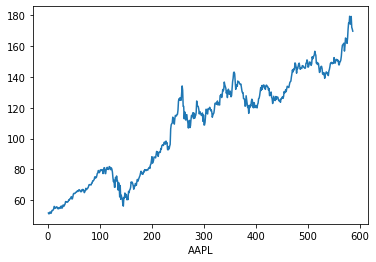

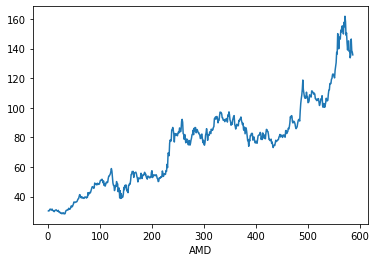

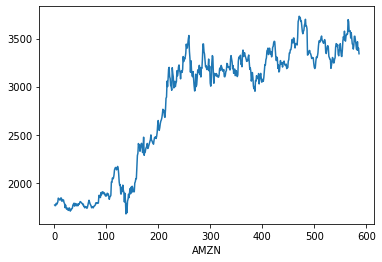

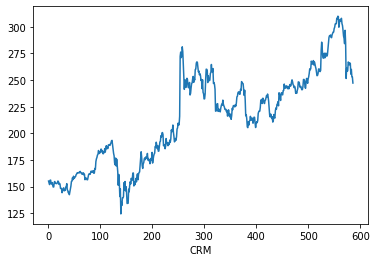

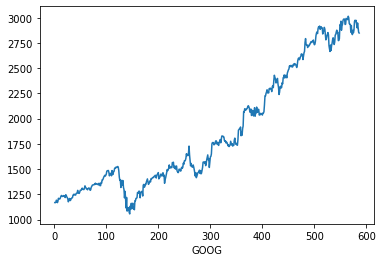

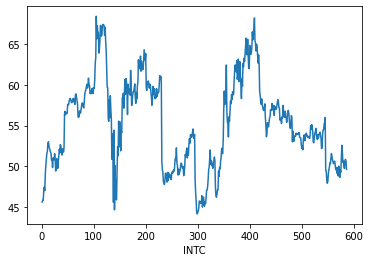

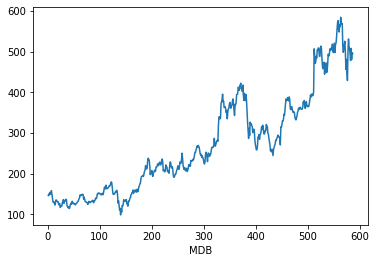

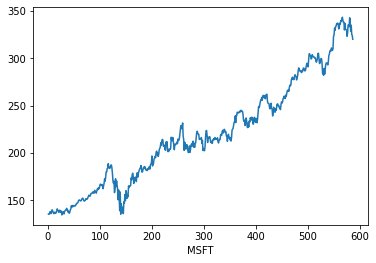

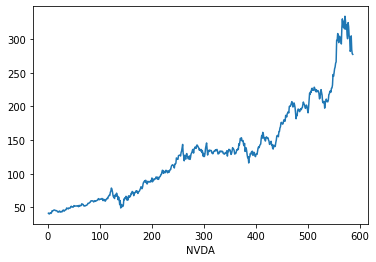

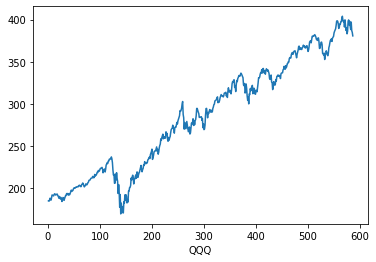

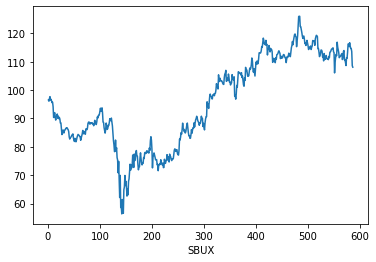

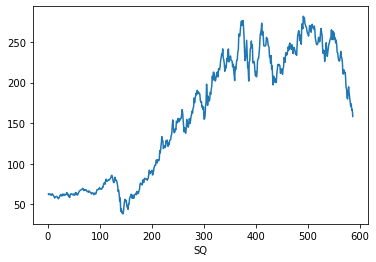

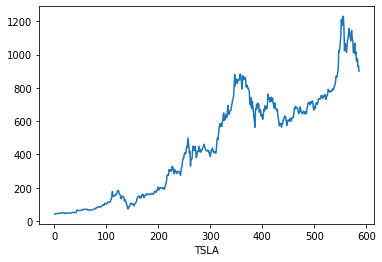

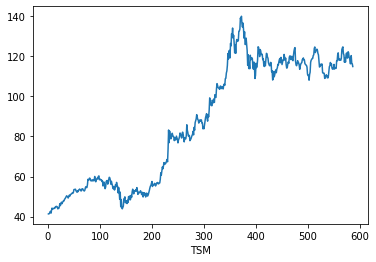

In [235]:
for i in stock_list:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

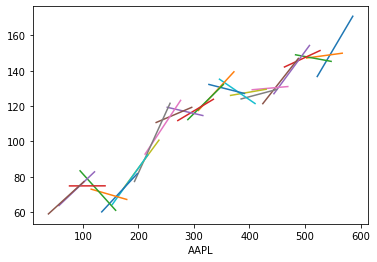

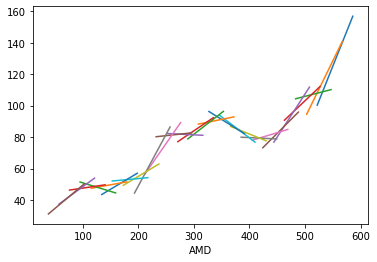

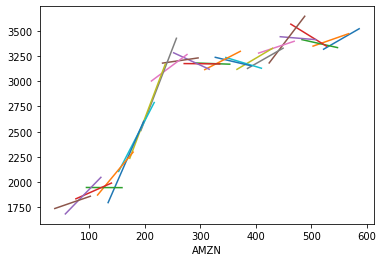

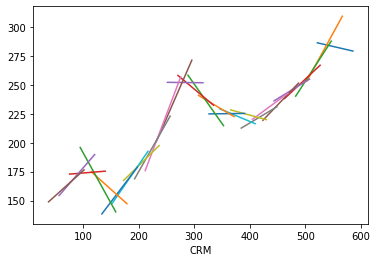

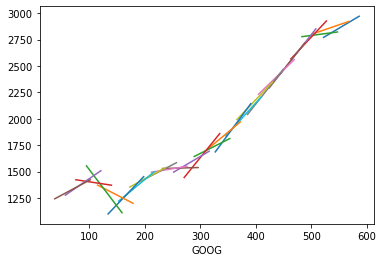

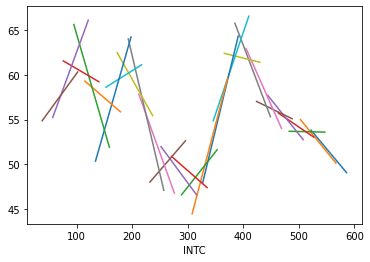

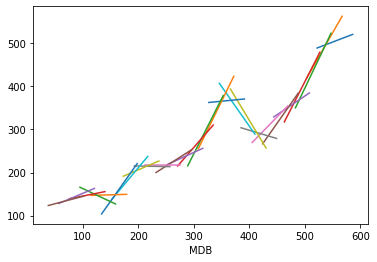

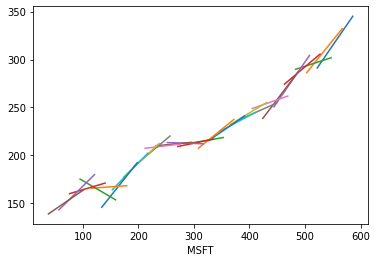

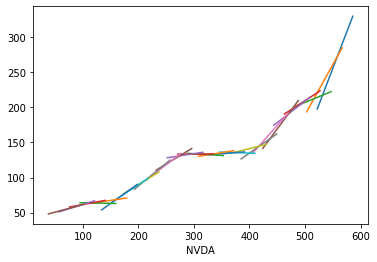

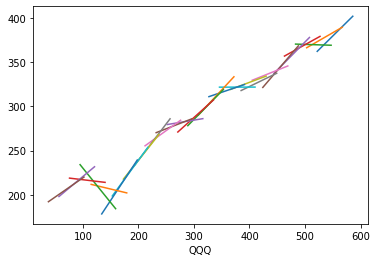

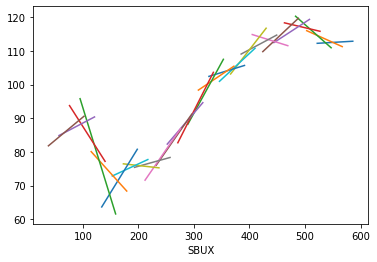

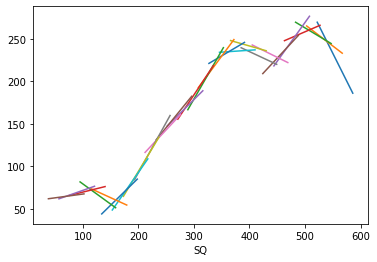

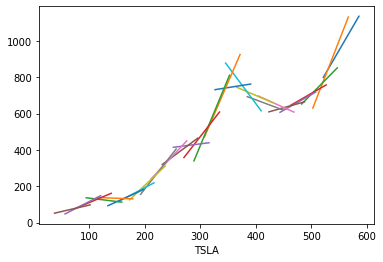

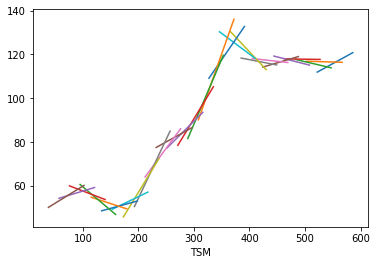

In [236]:
# plot only trendlines, bi-weekly, each line representing 1 year of data
# if the movement is too stable, these graphs won't be useable

for j in stock_list:
    for i in range(len(dataframes)):
        x = dataframes['data' + str(i)]['Index']
        y = dataframes['data' + str(i)][str(j)]

        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b)

    plt.xlabel(j)
    plt.show()

In [237]:
# create pred and pred/close list for each of the 50 dataframes
# may take 30+ seconds to run

k = len(dataframes)

for j in stock_list:
    for e in range(k):
        nlist = []
        ylist = []
        y = dataframes['data' + str(e)][str(j)]

        for i in range(1,len(dataframes['data0'])+1): # create pred
            x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
            m, b = np.polyfit(x, y, 1)
            d = m*i+b
            nlist.append(d)

        dataframes['data' + str(e)][str(j) + ' pred'] = nlist

        for i in range(1,len(dataframes['data0'])+1): # create pred/close
            d = (dataframes['data' + str(e)][str(j) + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][str(j)].iloc[i-1])
            ylist.append(d)

        dataframes['data' + str(e)][str(j) + ' pred/close'] = ylist

dataframes['data0']

C:\Users\james\AppData\Local\Temp/ipykernel_5400/2566930478.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred'] = nlist
C:\Users\james\AppData\Local\Temp/ipykernel_5400/2566930478.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred/close'] = ylist


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,...,QQQ pred,QQQ pred/close,SBUX pred,SBUX pred/close,SQ pred,SQ pred/close,TSLA pred,TSLA pred/close,TSM pred,TSM pred/close
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-20,142.940002,101.550003,3355.729980,258.220001,2780.340088,52.980000,489.269989,294.299988,211.130005,365.700012,...,361.992574,0.989862,112.232028,1.003685,269.579831,1.077328,799.073230,1.094366,111.839776,0.975063
2021-09-21,143.429993,102.820000,3343.629883,257.970001,2792.929932,52.869999,488.640015,294.799988,212.460007,366.149994,...,362.611998,0.990337,112.241681,1.000193,268.276047,1.067553,804.323312,1.087835,111.978735,0.974067
2021-09-22,145.850006,104.379997,3380.050049,259.170013,2818.770020,53.500000,510.679993,298.579987,219.410004,369.570007,...,363.231423,0.982849,112.251334,0.992760,266.972264,1.022608,809.573393,1.076646,112.117694,0.967616
2021-09-23,146.830002,106.150002,3416.000000,277.859985,2836.530029,54.029999,514.059998,299.559998,224.820007,372.980011,...,363.850847,0.975524,112.260987,0.983538,265.668481,0.996058,814.823475,1.081184,112.256653,0.966147
2021-09-24,146.919998,105.800003,3425.520020,285.630005,2852.659912,54.220001,508.040009,299.350006,220.809998,373.329987,...,364.470272,0.976268,112.270640,0.983881,264.364698,1.007104,820.073557,1.058993,112.395612,0.971944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14,174.330002,135.600006,3381.830078,255.589996,2899.409912,49.700001,478.549988,328.339996,283.369995,388.200012,...,399.158038,1.028228,112.811206,0.983447,191.352840,1.120858,1114.078133,1.162302,120.177311,1.033428
2021-12-15,179.300003,146.500000,3466.300049,260.040009,2947.370117,50.669998,508.410004,334.649994,304.589996,397.049988,...,399.777463,1.006869,112.820859,0.983788,190.049057,1.093493,1119.328215,1.146864,120.316270,0.999305
2021-12-16,172.259995,138.639999,3377.419922,253.119995,2896.770020,50.830002,481.019989,324.899994,283.869995,386.839996,...,400.396887,1.035045,112.830512,0.993314,188.745274,1.137842,1124.578297,1.213242,120.455229,1.033330


In [238]:
# pull the last 'close' and pred/close' from each dataframe in dataframes and make a new dataframe out of it
# each row is the last close price in a 1-year period and the final pred/close derived from a 1-year trendline
# the rows have a 50 week overlap and are separated by 2 weeks

df = pd.DataFrame()
add_index = np.arange(1,len(dataframes)+1)
df['Index'] = add_index

for j in stock_list:
    nlist = []
    ylist = []
    zlist = []
    k = len(dataframes['data0'])

    for e in reversed(range(len(dataframes))):
        nlist.append(round(dataframes['data' + str(e)][str(j) + ' pred/close'].iloc[k-1],4))
        ylist.append(round(dataframes['data' + str(e)][str(j)].iloc[k-1],4))
        zlist.append(round(dataframes['data' + str(e)][str(j) + ' pred'].iloc[k-1],2))

    df[str(j)] = pd.DataFrame(ylist)
    df[str(j) + ' pred'] = pd.DataFrame(zlist)
    df[str(j) + ' pred/close'] = pd.DataFrame(nlist)

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,SBUX pred/close,SQ,SQ pred,SQ pred/close,TSLA,TSLA pred,TSLA pred/close,TSM,TSM pred,TSM pred/close
16,17,131.24,121.44,0.9254,78.58,76.80,0.9774,3379.3899,3128.08,0.9256,...,0.9732,265.20,237.08,0.8940,701.98,615.09,0.8762,120.90,118.17,0.9774
17,18,126.85,129.51,1.0209,75.99,77.66,1.0220,3190.4900,3325.05,1.0422,...,1.0211,216.43,236.05,1.0906,629.04,660.92,1.0507,112.31,113.02,1.0064
18,19,125.90,129.38,1.0276,81.35,78.84,0.9691,3198.0100,3326.51,1.0402,...,1.0301,216.95,220.07,1.0144,605.13,619.98,1.0245,118.22,115.13,0.9738
19,20,142.02,131.04,0.9227,94.47,84.87,0.8984,3675.7400,3394.78,0.9236,...,0.9637,246.70,222.16,0.9005,659.58,607.88,0.9216,120.05,116.23,0.9681
20,21,145.52,146.92,1.0096,108.63,95.87,0.8825,3331.4800,3642.78,1.0934,...,0.9941,272.38,254.01,0.9326,709.67,664.29,0.9361,116.86,118.95,1.0179
21,22,153.12,154.23,1.0073,111.32,111.77,1.0040,3421.5701,3411.08,0.9969,...,1.0321,271.92,276.61,1.0172,730.91,717.54,0.9817,118.99,115.06,0.9670
22,23,145.37,151.36,1.0412,108.16,112.13,1.0367,3405.8000,3347.01,0.9827,...,1.0187,258.11,265.96,1.0304,791.36,757.34,0.9570,116.15,117.65,1.0129
23,24,148.64,145.27,0.9773,122.36,110.18,0.9005,3320.3701,3332.42,1.0036,...,0.9669,262.00,244.52,0.9333,1024.86,850.99,0.8303,113.64,113.80,1.0014
24,25,161.02,149.88,0.9308,152.52,140.69,0.9224,3572.5701,3470.04,0.9713,...,0.9982,211.31,233.16,1.1034,1156.87,1130.93,0.9776,124.75,116.33,0.9325
25,26,169.75,170.75,1.0059,135.80,156.82,1.1548,3341.5801,3519.00,1.0531,...,1.0440,158.30,186.14,1.1759,899.94,1135.08,1.2613,114.94,120.73,1.0504


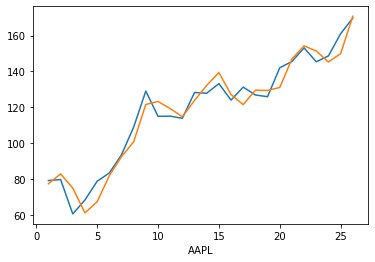

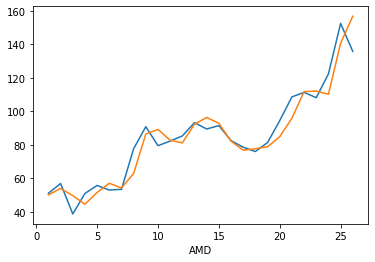

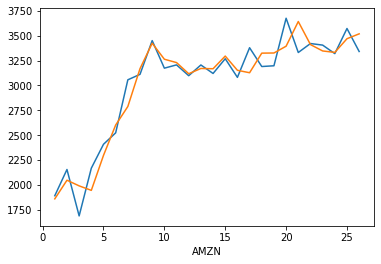

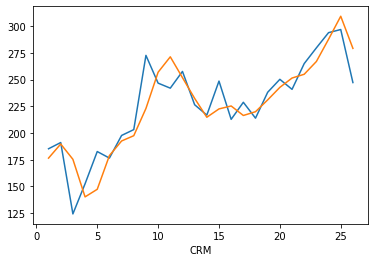

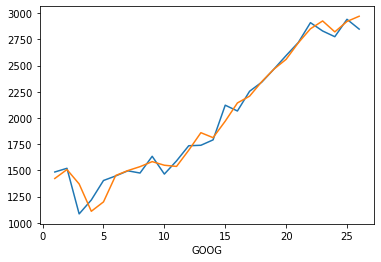

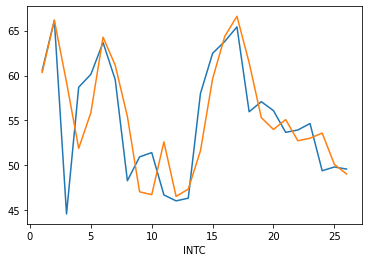

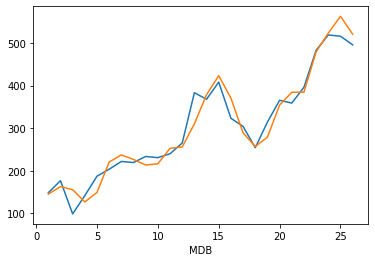

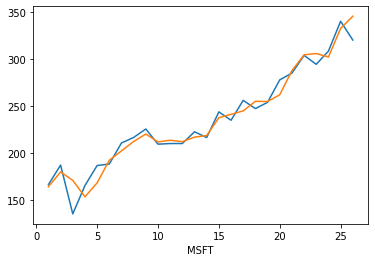

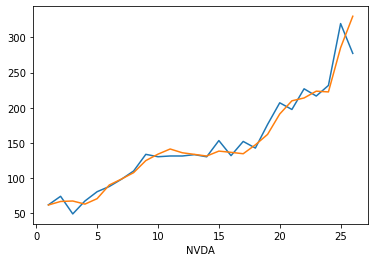

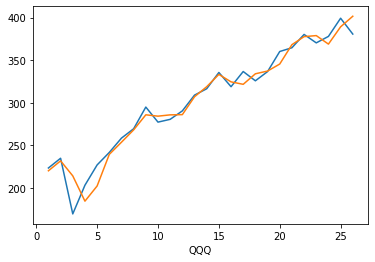

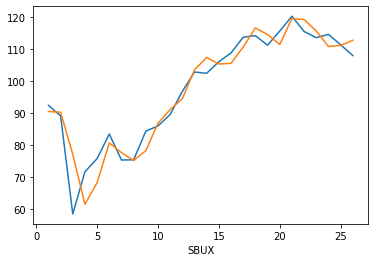

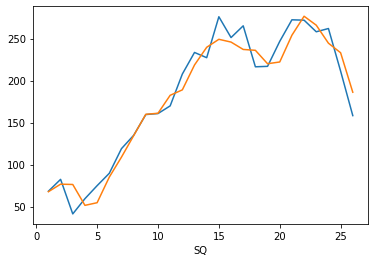

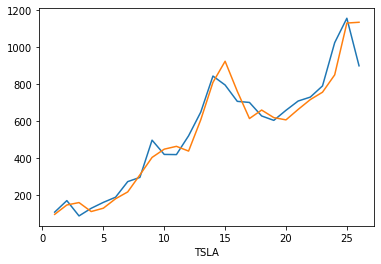

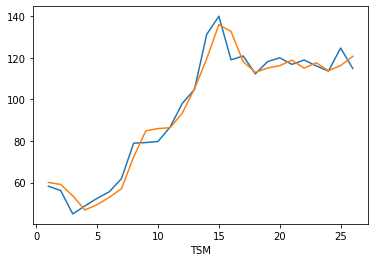

In [239]:
# plot for each stock the close price and the prediction price
# close (blue) below prediction (orange) = stock is underperforming

for i in stock_list:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    x = df['Index']
    y = df[str(i) + ' pred']
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

#### At this point, the foundation is set and strategies can be created and tested.

In [240]:
# determine the weeks where pred/close is >1 and therefore they are better weeks to buy in
# steady stocks could be at about 50/50 but stocks exponentially rising could have close to 0 pred/close > 1

for j in stock_list:
    nlist = []
    for i in range(len(df)):
        if df[str(j) + ' pred/close'].iloc[i] >= 1:
            nlist.append(1)
        else:
            nlist.append(0)

    df[str(j) + ' >1'] = nlist

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,GOOG >1,INTC >1,MDB >1,MSFT >1,NVDA >1,QQQ >1,SBUX >1,SQ >1,TSLA >1,TSM >1
16,17,131.24,121.44,0.9254,78.58,76.80,0.9774,3379.3899,3128.08,0.9256,...,0,1,0,0,0,0,0,0,0,0
17,18,126.85,129.51,1.0209,75.99,77.66,1.0220,3190.4900,3325.05,1.0422,...,1,1,1,1,1,1,1,1,1,1
18,19,125.90,129.38,1.0276,81.35,78.84,0.9691,3198.0100,3326.51,1.0402,...,0,0,0,1,0,1,1,1,1,0
19,20,142.02,131.04,0.9227,94.47,84.87,0.8984,3675.7400,3394.78,0.9236,...,0,0,0,0,0,0,0,0,0,0
20,21,145.52,146.92,1.0096,108.63,95.87,0.8825,3331.4800,3642.78,1.0934,...,0,1,1,1,1,1,0,0,0,1
21,22,153.12,154.23,1.0073,111.32,111.77,1.0040,3421.5701,3411.08,0.9969,...,0,0,0,1,0,0,1,1,0,0
22,23,145.37,151.36,1.0412,108.16,112.13,1.0367,3405.8000,3347.01,0.9827,...,1,0,0,1,1,1,1,1,0,1
23,24,148.64,145.27,0.9773,122.36,110.18,0.9005,3320.3701,3332.42,1.0036,...,1,1,1,0,0,0,0,0,0,1
24,25,161.02,149.88,0.9308,152.52,140.69,0.9224,3572.5701,3470.04,0.9713,...,0,1,1,0,0,0,0,1,0,0
25,26,169.75,170.75,1.0059,135.80,156.82,1.1548,3341.5801,3519.00,1.0531,...,1,0,1,1,1,1,1,1,1,1


In [241]:
# square the pred/close number as a more extreme option for calculations

for j in stock_list:
    df[str(j) +' pred/close2'] = round(df[str(j) +' pred/close']**2,4) # make the value differences a little more pronounced

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,GOOG pred/close2,INTC pred/close2,MDB pred/close2,MSFT pred/close2,NVDA pred/close2,QQQ pred/close2,SBUX pred/close2,SQ pred/close2,TSLA pred/close2,TSM pred/close2
16,17,131.24,121.44,0.9254,78.58,76.80,0.9774,3379.3899,3128.08,0.9256,...,0.9590,1.0365,0.9035,0.9147,0.7834,0.9126,0.9471,0.7992,0.7677,0.9553
17,18,126.85,129.51,1.0209,75.99,77.66,1.0220,3190.4900,3325.05,1.0422,...,1.0042,1.2045,1.0211,1.0634,1.0658,1.0512,1.0426,1.1894,1.1040,1.0128
18,19,125.90,129.38,1.0276,81.35,78.84,0.9691,3198.0100,3326.51,1.0402,...,0.9998,0.9390,0.7880,1.0068,0.8460,1.0036,1.0611,1.0290,1.0496,0.9483
19,20,142.02,131.04,0.9227,94.47,84.87,0.8984,3675.7400,3394.78,0.9236,...,0.9724,0.9270,0.9397,0.8894,0.8521,0.9199,0.9287,0.8109,0.8493,0.9372
20,21,145.52,146.92,1.0096,108.63,95.87,0.8825,3331.4800,3642.78,1.0934,...,0.9978,1.0535,1.1464,1.0185,1.1287,1.0199,0.9882,0.8697,0.8763,1.0361
21,22,153.12,154.23,1.0073,111.32,111.77,1.0040,3421.5701,3411.08,0.9969,...,0.9604,0.9563,0.9426,1.0042,0.8885,0.9864,1.0652,1.0347,0.9637,0.9351
22,23,145.37,151.36,1.0412,108.16,112.13,1.0367,3405.8000,3347.01,0.9827,...,1.0689,0.9411,0.9847,1.0793,1.0646,1.0467,1.0377,1.0617,0.9158,1.0260
23,24,148.64,145.27,0.9773,122.36,110.18,0.9005,3320.3701,3332.42,1.0036,...,1.0335,1.1766,1.0167,0.9598,0.9222,0.9528,0.9349,0.8710,0.6894,1.0028
24,25,161.02,149.88,0.9308,152.52,140.69,0.9224,3572.5701,3470.04,0.9713,...,0.9860,1.0114,1.1901,0.9557,0.7969,0.9500,0.9964,1.2175,0.9557,0.8696
25,26,169.75,170.75,1.0059,135.80,156.82,1.1548,3341.5801,3519.00,1.0531,...,1.0881,0.9781,1.1038,1.1640,1.4171,1.1130,1.0899,1.3827,1.5909,1.1033


In [242]:
# Create all of the strategies to test 

for j in stock_list:
    
# baseline - buy in $10 bi-weekly no matter what - baseline
    df[str(j) +' baseline'] = 0
    df[str(j) +' baseline_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' baseline'].iloc[i] = contrib_amt
        df[str(j) +' baseline_stk'].iloc[i] = df[str(j) +' baseline'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt
        if v < contrib_amt:
            break

# opt1 - buy in every other week but proportionally to the pred/close
    df[str(j) +' opt1'] = 0
    df[str(j) +' opt1_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt1'].iloc[i] = contrib_amt*df[str(j) +' pred/close'].iloc[i]
        df[str(j) +' opt1_stk'].iloc[i] = df[str(j) +' opt1'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt*df[str(j) +' pred/close'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt*df[str(j) +' pred/close'].iloc[t]:
            break

# opt2 - buy in every other week but proportionally to the square of pred/close
    df[str(j) +' opt2'] = 0
    df[str(j) +' opt2_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt2'].iloc[i] = contrib_amt*df[str(j) +' pred/close2'].iloc[i]
        df[str(j) +' opt2_stk'].iloc[i] = df[str(j) +' opt2'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt*df[str(j) +' pred/close2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt*df[str(j) +' pred/close2'].iloc[t]:
            break

# opt3 - buy in every other week. 0 on days <1 and twice the normal bi-weekly contribution on days >= 1
    df[str(j) +' opt3'] = 0
    df[str(j) +' opt3_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt3'].iloc[i] = contrib_amt*2*df[str(j) +' >1'].iloc[i] 
        df[str(j) +' opt3_stk'].iloc[i] = df[str(j) +' opt3'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt*2*df[str(j) +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt*2*df[str(j) +' >1'].iloc[t]:
            break

# opt4 - buy in every other week but proportionally to the inverse of pred/close
# This is more of a validation and will ideally return negative compared to baseline
    df[str(j) +' opt4'] = 0
    df[str(j) +' opt4_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt4'].iloc[i] = contrib_amt/df[str(j) +' pred/close'].iloc[i]
        df[str(j) +' opt4_stk'].iloc[i] = df[str(j) +' opt4'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt/df[str(j) +' pred/close'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt/df[str(j) +' pred/close'].iloc[t]:
            break

df.tail(10)

C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Temp/ipykernel_5400/860918052.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j) +' opt4_stk'] = 0
C:\Users\james\AppData\Local\Temp/ipykernel_5400/860918052.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,TSM baseline,TSM baseline_stk,TSM opt1,TSM opt1_stk,TSM opt2,TSM opt2_stk,TSM opt3,TSM opt3_stk,TSM opt4,TSM opt4_stk
16,17,131.24,121.44,0.9254,78.58,76.80,0.9774,3379.3899,3128.08,0.9256,...,10,0.082713,9.774,0.080844,9.553,0.079016,0,0.000000,10.231226,0.084626
17,18,126.85,129.51,1.0209,75.99,77.66,1.0220,3190.4900,3325.05,1.0422,...,10,0.089039,10.064,0.089609,10.128,0.090179,20,0.178079,9.936407,0.088473
18,19,125.90,129.38,1.0276,81.35,78.84,0.9691,3198.0100,3326.51,1.0402,...,10,0.084588,9.738,0.082372,9.483,0.080215,0,0.000000,10.269049,0.086864
19,20,142.02,131.04,0.9227,94.47,84.87,0.8984,3675.7400,3394.78,0.9236,...,10,0.083299,9.681,0.080641,9.372,0.078067,0,0.000000,10.329511,0.086043
20,21,145.52,146.92,1.0096,108.63,95.87,0.8825,3331.4800,3642.78,1.0934,...,10,0.085572,10.179,0.087104,10.361,0.088662,20,0.171145,9.824148,0.084068
21,22,153.12,154.23,1.0073,111.32,111.77,1.0040,3421.5701,3411.08,0.9969,...,10,0.084041,9.670,0.081267,9.351,0.078586,0,0.000000,10.341262,0.086909
22,23,145.37,151.36,1.0412,108.16,112.13,1.0367,3405.8000,3347.01,0.9827,...,10,0.086096,10.129,0.087206,10.260,0.088334,20,0.172191,9.872643,0.084999
23,24,148.64,145.27,0.9773,122.36,110.18,0.9005,3320.3701,3332.42,1.0036,...,10,0.087997,10.014,0.088120,10.028,0.088244,20,0.175994,9.986020,0.087874
24,25,161.02,149.88,0.9308,152.52,140.69,0.9224,3572.5701,3470.04,0.9713,...,10,0.080160,9.325,0.074749,8.696,0.069707,0,0.000000,10.723861,0.085963
25,26,169.75,170.75,1.0059,135.80,156.82,1.1548,3341.5801,3519.00,1.0531,...,10,0.087002,10.504,0.091387,0.000,0.000000,20,0.174004,0.000000,0.000000


In [243]:
print('baseline - contribute 10 every other week')
print('opt1 - buy in every other week proportional to the pred/close variable')
print('opt2 - buy in every other week proportional to the square of pred/close variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/close variable')

df_bought_in = pd.DataFrame()
df_profit = pd.DataFrame()
df_diff = pd.DataFrame()

for j in stock_list:
    d = {'name': [str(j) +' baseline', str(j) +' op1', str(j) +' op2', str(j) +' op3', str(j) +' op4']
         ,'bought_in': [
             round(sum(df[str(j) +' baseline']),2),
             round(sum(df[str(j) +' opt1']),2), 
             round(sum(df[str(j) +' opt2']),2), 
             round(sum(df[str(j) +' opt3']),2),
             round(sum(df[str(j) +' opt4']),2)]
         ,'stocks_held': [
             round(sum(df[str(j) +' baseline_stk']),4), 
             round(sum(df[str(j) +' opt1_stk']),4), 
             round(sum(df[str(j) +' opt2_stk']),4), 
             round(sum(df[str(j) +' opt3_stk']),4), 
             round(sum(df[str(j) +' opt4_stk']),4)]
#          ,'cost_per_stock': [
#              sum(df[str(j) +' baseline'])/sum(df[str(j) +' baseline_stk']), 
#              sum(df[str(j) +' opt1'])/sum(df[str(j) +' opt1_stk']), 
#              sum(df[str(j) +' opt2'])/sum(df[str(j) +' opt2_stk']), 
#              sum(df[str(j) +' opt3'])/sum(df[str(j) +' opt3_stk']), 
#             sum(df[str(j) +' opt4'])/sum(df[str(j) +' opt4_stk'])]
         ,'profit': [
             round((sum(df[str(j) +' baseline_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' baseline']),2),
             round((sum(df[str(j) +' opt1_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt1']),2), 
             round((sum(df[str(j) +' opt2_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt2']),2), 
             round((sum(df[str(j) +' opt3_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt3']),2), 
             round((sum(df[str(j) +' opt4_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt4']),2)]
        }

    df2 = pd.DataFrame(data=d)

    df2['diff'] = 0
    df2['diff'].iloc[1] = round(df2['profit'].iloc[1]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[2] = round(df2['profit'].iloc[2]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[3] = round(df2['profit'].iloc[3]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[4] = round(df2['profit'].iloc[4]-df2['profit'].iloc[0],2)

    df2['%_diff'] = round((df2['diff']/df2['profit'])*100,2)

    print('')
    print(df2)
    
    df_bought_in[str(j) + ' bought_in'] = df2['bought_in']
    df_profit[str(j) + ' profit'] = df2['profit']
    df_diff[str(j) + ' diff'] = df2['diff']

baseline - contribute 10 every other week
opt1 - buy in every other week proportional to the pred/close variable
opt2 - buy in every other week proportional to the square of pred/close variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1
opt4 - buy in every other week inversely proportional to the pred/close variable

            name  bought_in  stocks_held  profit   diff  %_diff
0  AAPL baseline     260.00       2.3562  139.96   0.00    0.00
1       AAPL op1     258.97       2.3556  140.89   0.93    0.66
2       AAPL op2     259.26       2.3722  143.41   3.45    2.41
3       AAPL op3     260.00       2.2946  129.51 -10.45   -8.07
4       AAPL op4     252.36       2.3142  140.48   0.52    0.37

           name  bought_in  stocks_held  profit   diff  %_diff
0  AMD baseline     260.00       3.4178  204.13   0.00    0.00
1       AMD op1     257.90       3.4231  206.95   2.82    1.36
2       AMD op2     258.21       3.4684  212.80   8.67 

C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [244]:
# how much was ivested
# no amount should be above the previously set 'invest' amount
# row 0 = baselines. Rows 1-4 = options 1-4
df_bought_in

,AAPL bought_in,AMD bought_in,AMZN bought_in,CRM bought_in,GOOG bought_in,INTC bought_in,MDB bought_in,MSFT bought_in,NVDA bought_in,QQQ bought_in,SBUX bought_in,SQ bought_in,TSLA bought_in,TSM bought_in
0,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00
1,258.97,257.90,249.74,259.96,250.30,252.80,251.94,249.43,259.50,259.86,250.13,250.04,258.12,259.73
2,259.26,258.21,250.31,250.29,251.83,257.75,258.94,249.86,247.60,249.62,251.74,259.17,250.63,249.52
3,260.00,220.00,260.00,200.00,240.00,260.00,260.00,260.00,260.00,200.00,240.00,220.00,180.00,240.00
4,252.36,255.77,251.07,253.96,250.81,259.19,252.11,251.45,254.51,251.57,251.17,256.07,251.38,251.77


In [245]:
# profits made above/below the investment
# row 0 = baselines. Rows 1-4 = options 1-4
df_profit

,AAPL profit,AMD profit,AMZN profit,CRM profit,GOOG profit,INTC profit,MDB profit,MSFT profit,NVDA profit,QQQ profit,SBUX profit,SQ profit,TSLA profit,TSM profit
0,139.96,204.13,39.67,35.16,144.19,-22.89,248.65,111.15,340.66,82.09,37.81,42.01,455.99,94.34
1,140.89,206.95,40.51,38.16,146.01,-21.90,264.39,112.82,349.87,83.53,39.25,60.72,493.08,96.21
2,143.41,212.80,41.75,42.98,149.43,-20.84,295.06,115.59,366.76,86.01,41.71,100.82,596.21,98.91
3,129.51,184.81,36.56,33.62,144.61,-18.82,226.60,105.86,337.82,54.96,37.14,16.93,294.75,90.81
4,140.48,204.01,39.19,33.54,143.77,-23.86,243.27,110.42,337.48,81.53,37.21,35.64,461.60,93.21


In [246]:
# profits made above/below the baseline profits
# row 0 = baselines. Rows 1-4 = options 1-4
df_diff[1:5]

,AAPL diff,AMD diff,AMZN diff,CRM diff,GOOG diff,INTC diff,MDB diff,MSFT diff,NVDA diff,QQQ diff,SBUX diff,SQ diff,TSLA diff,TSM diff
1,0.93,2.82,0.84,3.00,1.82,0.99,15.74,1.67,9.21,1.44,1.44,18.71,37.09,1.87
2,3.45,8.67,2.08,7.82,5.24,2.05,46.41,4.44,26.10,3.92,3.90,58.81,140.22,4.57
3,-10.45,-19.32,-3.11,-1.54,0.42,4.07,-22.05,-5.29,-2.84,-27.13,-0.67,-25.08,-161.24,-3.53
4,0.52,-0.12,-0.48,-1.62,-0.42,-0.97,-5.38,-0.73,-3.18,-0.56,-0.60,-6.37,5.61,-1.13


In [247]:
# Final summary calculations
# if you take chosen stocks and apply chosen investment strategies over the course of 2 years, 
# investing bi-weekly, you get these results:

print('Current date/time: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
print('')

print('baseline - contribute 10 every other week')
print('opt1 - buy in every other week proportional to the pred/close variable')
print('opt2 - buy in every other week proportional to the square of pred/close variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/close variable')
print('')

# needed for when baseline total profit is negative
if sum(df_profit.iloc[0]) >= 0:
      x = 1
else:
      x = -1

if sum(df_diff.iloc[1]) >= 0:
      print(round(sum(df_diff.iloc[1]),2), 'opt1 profit over baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[1]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[2]) >= 0:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 profit over baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[3]) >= 0:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 profit over baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 loss compared to baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[4]) >= 0:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 profit over baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 loss compared to baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')


Current date/time:  December 20, 2021 22:02:36

baseline - contribute 10 every other week
opt1 - buy in every other week proportional to the pred/close variable
opt2 - buy in every other week proportional to the square of pred/close variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1
opt4 - buy in every other week inversely proportional to the pred/close variable

97.57 opt1 profit over baseline. 2050.49 core profit on 3568.42 investment. 5.0 percent above baseline profit.
317.68 opt2 profit over baseline. 2270.6 core profit on 3544.73 investment. 16.27 percent above baseline profit.
-277.76 opt3 loss compared to baseline. 1675.16 core profit on 3300.0 investment. -14.22 percent below baseline profit.
-15.43 opt4 loss compared to baseline. 1937.49 core profit on 3543.19 investment. -0.79 percent below baseline profit.


In [248]:
print("Using one of the strategies, today's buy in values are listed.")

now = pd.DataFrame()
opts = ['opt1', 'opt2', 'opt3', 'opt4']
now['method'] = opts

for j in stock_list:
    nlist = []
    for i in range(1, len(opts)+1):
        if i == 1: 
            x = contrib_amt * df[str(j) + ' pred/close'].iloc[invest_weeks-1]
        elif i == 2:
            x = contrib_amt * df[str(j) + ' pred/close2'].iloc[invest_weeks-1]
        elif i == 3:
            x = contrib_amt * 2 * df[str(j) + ' >1'].iloc[invest_weeks-1]
        elif i == 4: 
            x = contrib_amt / df[str(j) + ' pred/close'].iloc[invest_weeks-1]
        else: -1
        nlist.append(round(x,2))
    now[str(j)] = nlist

now

Using one of the strategies, today's buy in values are listed.


,method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,opt1,10.06,11.55,10.53,11.29,10.43,9.89,10.51,10.79,11.90,10.55,10.44,11.76,12.61,10.50
1,opt2,10.12,13.34,11.09,12.76,10.88,9.78,11.04,11.64,14.17,11.13,10.90,13.83,15.91,11.03
2,opt3,20.00,20.00,20.00,20.00,20.00,0.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
3,opt4,9.94,8.66,9.50,8.85,9.59,10.11,9.52,9.27,8.40,9.48,9.58,8.50,7.93,9.52


#### "Final" notes

Stocks going up parabolically will almost never be above 1, so I can't simply not buy in when pred/close is not above 1. GOOG is like this as of 9/3/2021. This kind of stock will also produce worse than baseline profits for opt1 and opt2 because they won't be investing the full 500 over the course of the investment period. Option 3 is not viable.

Stocks in a big S-curve, flat ~ rise ~ flat, will only have a pred/close above 1 on the latter half of the year, so again, I can't contribute nothing. TSM and TSLA are like this as of 9/3/2021. Option 3 is not viable.

Options 1 and 2 seem to do well on stocks with lots of variation but loses on stocks seeing exponential growth. Missing out on a stock growing exponentially will surely wipe out all gains seen elsewhere. There may be some merit to opt4, the inverse method, but the baseline probably remains the best method if a single method is picked, and based only on daily closing values, for across the board investing.

#### Round 2 running notes - 12/15/2021
rolling 1 quarter has already shown to be better than at least 1 year or 1 month<br>
1 quarter instead of my original hypothesis of 1 year seems to be much more promising<br>
opt2 focus<br>
excluded MDB due to shorter stock lifespan<b>

Current run, 3 year period ending 12/15/2021:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2018-12-15' - '2021-12-15'<br>
Rolling: 65 days (~1 quarter)<br>
353.39 opt2 profit over baseline. 4425.11 core profit on 6425.96 investment. 8.68 percent above baseline profit.<br>
TSLA represents most of the gains over baseline, but no individual stock did worse than baseline.<br>

Worst case end run ending on the worst part of the COVID nosedive:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-03-20' - '2020-03-20'<br>
Rolling: 65 days (~1 quarter)<br>
19.21 opt2 profit over baseline. 489.81 core profit on 6408.78 investment. 4.08 percent above baseline profit.<br>
GOOG and SBUX were worse than baseline, but not more than $1 different. Good stability<br>

Best case end run ending right before the COVID drop:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-02-14' - '2020-02-14'<br>
Rolling: 65 days (~1 quarter)<br>
18.16 opt2 profit over baseline. 3576.39 core profit on 6445.56 investment. 0.51 percent above baseline profit.<br>
TSLA has 18.40 in gains over baseline, the rest were almost a wash<br>
